# EDA
In this notebook, we will further investigate our data and make reasonable adjustments and engineering to features. Feature engineering is integrated into this process.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50
plt.style.use('ggplot')

In [3]:
df = pd.read_pickle('PKL/clean_df.pkl')

In [4]:
df.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.9381,-9.8563,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.6988,-2.1475,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,None,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Data Types
### ID
ID is not a reliable predictor, we will remove this column.

In [5]:
# add them to colstodrop list and drop all at once later
colstodrop = ['id']

### Recorded Date
We will only keep years as integers. We have decided to keep the recorded year as it can indicate the current time point. We are assuming that recorded date is not post-outcome variable. (In other words, we are assuming that 'recording' does not involve physical checking the status of well to determine the final outcome, rather it is a recorded date of predictors. If it is in fact post-outcome variable, we should remove it.)

In [6]:
df.date_recorded = [int(x[:4]) for x in df.date_recorded]

### Region code & District code
Even though they are integers, they should be categorical values as they don't have continuous relationship to the target. We'll change their data type.

In [7]:
# convert region_code and district_code to be objects.
df['region_code'] = df.region_code.astype('object')
df['district_code'] = df.district_code.astype('object')

## Target Variables
Let's see how our target variable is distributed.

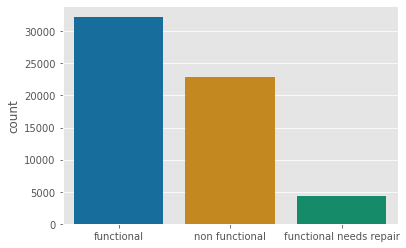

In [8]:
fig = plt.figure(figsize = (6, 4))
sns.countplot(df.status_group, palette = 'colorblind')
plt.xlabel('')
fig.patch.set_visible(False)
plt.show()

In [9]:
df.status_group.value_counts(normalize = True)

functional                 0.5431
non functional             0.3842
functional needs repair    0.0727
Name: status_group, dtype: float64

Our target variable has some class imbalance issue. 
More than half of our training data are fully functional, while less than 10% are functional but requires repair.

# Continuous variables
I'll take a look at the continuous variables first.

## Total Static Head
Total static head is the vertical distance water travels at the pump.

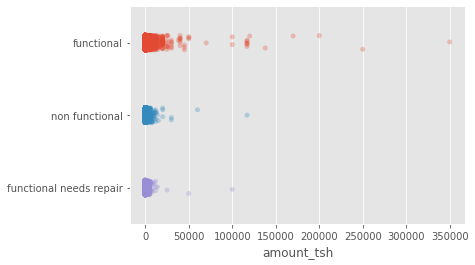

In [10]:
fig = plt.figure(figsize = (6, 4))
sns.stripplot(x = 'amount_tsh', y = 'status_group', data = df, alpha = 0.3)
plt.ylabel('')
fig.patch.set_visible(False)
plt.show()

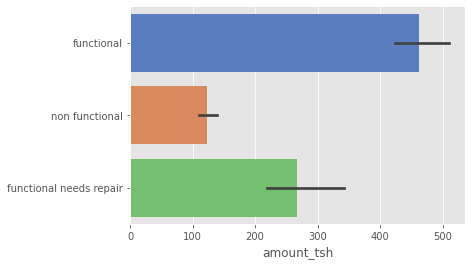

In [11]:
fig = plt.figure(figsize = (6, 4))
sns.barplot(x = 'amount_tsh', y = 'status_group', data = df, palette = 'muted')
plt.ylabel('')
fig.patch.set_visible(False)
plt.show()

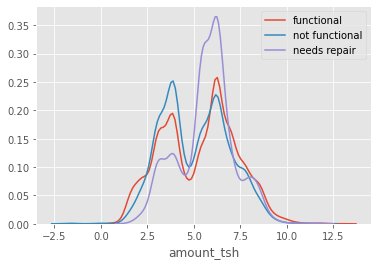

In [12]:
fig = plt.figure(figsize = (6, 4))

tmp = df[df.amount_tsh!=0]
sns.distplot(np.log(tmp[tmp.status_group == 'functional'].amount_tsh), hist = False, 
            label='functional')
sns.distplot(np.log(tmp[tmp.status_group == 'non functional'].amount_tsh), hist = False, 
            label = 'not functional')
sns.distplot(np.log(tmp[tmp.status_group == 'functional needs repair'].amount_tsh), hist = False, 
            label = 'needs repair')

plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()                 

Most values are very small with a few high extreme values. Mean difference between classes are likely caused by these extreme values. These high value would impact our model. But since the unit information is not present, I cannot figure out if these outliers are error or not. Normalizing these values show a bit of bimodal look. We should consider adding a column to account for this bimodality. (Since we will be primarily running tree-based models, we won't normalize the value at this stage.)

## Altitude of the well (gps_height)


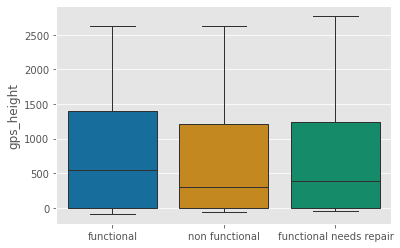

In [13]:
fig = plt.figure(figsize = (6, 4))

sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df, linewidth = 1, palette = 'colorblind')
plt.xlabel('')
fig.patch.set_visible(False)
plt.show()

There are some negative altitude, which probably means that the well goes below the sea level. This could have an implication. We will add a binary feature to show this. Also many are 0, this is also possibly missing values, but there's no evidence to discount it, so I'll add a feature to take this into account..

In [14]:
df['negative_gps_height'] = np.where(df.gps_height < 0, 1, 0)
df['zero_gps_height'] = np.where(df.gps_height == 0, 1, 0)

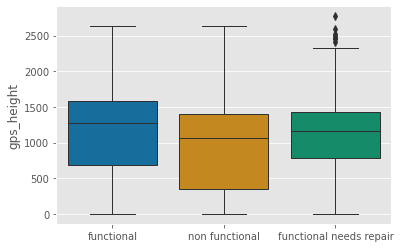

In [15]:
# without negative or zero values
fig = plt.figure(figsize = (6, 4))

sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df[df.gps_height > 0], linewidth = 1, palette = 'colorblind')
plt.xlabel('')
fig.patch.set_visible(False)
plt.show()

Functional seems to have a slightly higher gps height.

In [16]:
import scipy.stats as st
st.ttest_ind(df[(df.gps_height > 0) & (df.status_group == 'functional')].gps_height, 
             df[(df.gps_height > 0) & (df.status_group == 'non functional')].gps_height)

Ttest_indResult(statistic=30.600722658837718, pvalue=5.754674377100651e-203)

Only looking at the difference between functional and non functional, even just with positive values, there are significant difference in gps height between functional and non functional group. Including all values also show significant difference.

In [21]:
st.ttest_ind(df[(df.status_group == 'functional')].gps_height, 
             df[(df.status_group == 'non functional')].gps_height)

Ttest_indResult(statistic=27.693893314674337, pvalue=1.1731581254435202e-167)

## Longitude & Latitude

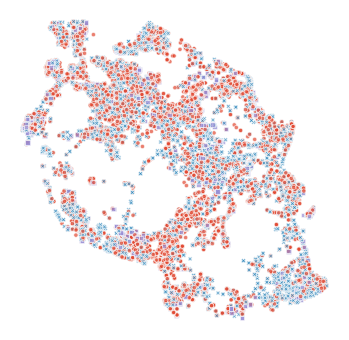

In [17]:
# new version of matplotlib update breaks the legend

tmp = df.copy()
tmp['status_group'] = tmp.status_group.replace({'functional':2, 'function needs repair':1, 'non functional': 0})

fig = plt.figure(figsize = (6, 6))

try:
    ax = sns.scatterplot(x="longitude", y="latitude", hue ='status_group',
                size = 0.5, alpha = 0.7, style="status_group", data=tmp, legend=False)
except: 
    ax = sns.scatterplot(x="longitude", y="latitude", hue ='status_group',
                size = 0.5, alpha = 0.7, style="status_group", data=df, legend=False)

plt.xlabel('')
ax.axis('off')
fig.patch.set_visible(False)
plt.show()

It seems like there are some clustering that divides functionality in some locations, we will explore more into location and distance measures later.

## Num_private
there's no information on what this value is. Most values are 0.

In [19]:
#df.num_private.value_counts()

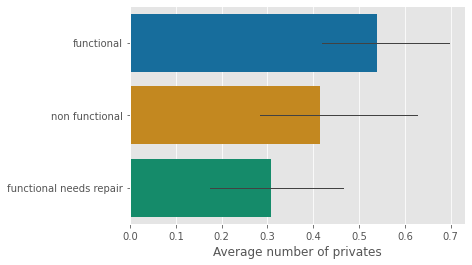

In [20]:
fig = plt.figure(figsize = (6, 4))

sns.barplot(y = 'status_group', x = 'num_private',
            data = df, errwidth = 1, palette = 'colorblind')
plt.xlabel('Average number of privates')
plt.ylabel('')
fig.patch.set_visible(False)
plt.show()

In [24]:
st.ttest_ind(df[(df.status_group == 'functional')].num_private, 
             df[(df.status_group == 'functional needs repair')].num_private)

Ttest_indResult(statistic=1.2053480457811359, pvalue=0.2280767674646928)

Simple t-test shows that the difference in the number or privates shown in above graph is not statistically significant.

## Construction year
As seen in the cleaning notebook, we have many 0 values. I will first look at ones without 0 values to see if there is any importance.

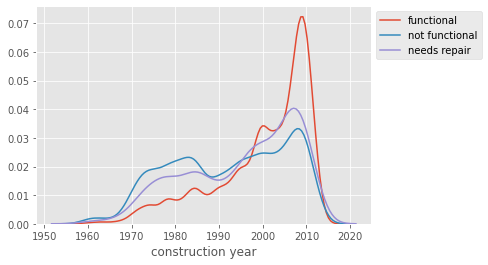

In [26]:
fig = plt.figure(figsize = (6, 4))

tmp = df[df.construction_year!=0]
sns.distplot(tmp[tmp.status_group == 'functional'].construction_year, hist = False, 
            label='functional')
sns.distplot(tmp[tmp.status_group == 'non functional'].construction_year, hist = False, 
            label = 'not functional')
sns.distplot(tmp[tmp.status_group == 'functional needs repair'].construction_year, hist = False, 
            label = 'needs repair')

plt.legend(bbox_to_anchor = [1, 1])
plt.xlabel('construction year')
fig.patch.set_visible(False)
plt.show()
                 

It seems like many of functional wells were built recently.

Since construction year data seems important but mostly missing. we will turn this into categorical columns with several bins.

In [27]:
cond = [df.construction_year > 2005, 
       df.construction_year > 2000, 
       df.construction_year > 1990, 
       df.construction_year > 1980, 
       df.construction_year > 1970]
vals = ['after05', '00s', '90s', '80s', '70s']

df['built_recent'] = np.select(cond, vals, 'others')

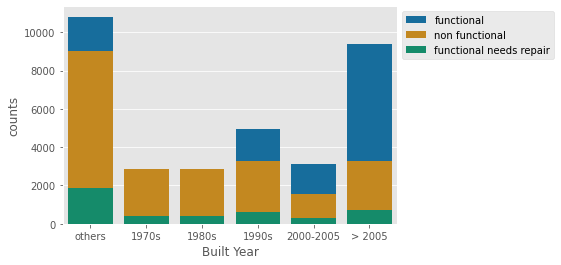

In [54]:
fig = plt.figure(figsize = (6, 4))

sns.countplot(hue = 'status_group', x = 'built_recent', dodge = False,
            data = df, order = ['others', '70s', '80s', '90s', '00s', 'after05'], 
              palette = 'colorblind')

plt.xticks(range(0, 6), ['others', '1970s', '1980s', '1990s', '2000-2005', '> 2005'])
plt.xlabel('Built Year')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

It seems like the older water points are not maintained at all.

## Population
Most values are 0, but since many are 1, I'm guessing this means that most wells are far from the residential areas.

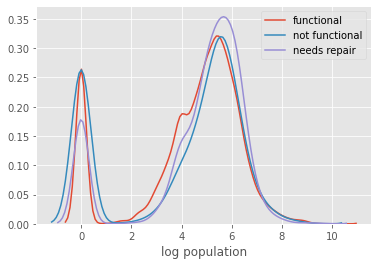

In [56]:
fig = plt.figure(figsize = (6, 4))

tmp = df[df.population!=0]
sns.distplot(np.log(tmp[tmp.status_group == 'functional'].population), hist = False, 
            label='functional')
sns.distplot(np.log(tmp[tmp.status_group == 'non functional'].population), hist = False, 
            label = 'not functional')
sns.distplot(np.log(tmp[tmp.status_group == 'functional needs repair'].population), hist = False, 
            label = 'needs repair')

plt.xlabel('log population')
plt.ylabel('')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()


## Categorical values
Now we will look at other categorical values.

In [57]:
len(set(df.installer)) == len(set([x.lower() for x in df.installer]))

False

It seems like we need to turn all texts into lower case in order to account for any text mishaps.

In [58]:
text_feats = ['funder', 'installer', 'wpt_name', 'basin', 
 'subvillage', 'region', 'lga', 'ward',  
 'scheme_management', 'scheme_name', 'extraction_type',
 'extraction_type_group', 'extraction_type_class', 'management',
 'management_group', 'payment', 'payment_type', 'water_quality',
 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
 'source_class', 'waterpoint_type', 'waterpoint_type_group']

for c in text_feats:
    df[c] = [x.lower() for x in df[c]]

### Category Datatype
Most categorical values are strings, and it can confuse pandas. so we'll transform them into categories. (This process probably isn't necessary)

In [59]:
categories = list(df.select_dtypes('object').columns)
df[categories] = df[categories].astype('category')

Additionally quantity and quantity_group seems to be the same thing so we will remove quantity_group.

In [60]:
# df[df.quantity != df.quantity_group]
colstodrop = colstodrop + ['quantity_group']

### Funder & Installer
There are many funder and installers. Turning all of them as a dummy is computationally expensive. Instead we'll group values that have less than 100 values into others. Before we do that, we'll put some effort to salvage some of the typos and different abbreviations.

##### Fixing Typos
Before, let's fix some typos.

In [61]:
swedish = ['swedish', 'sweeden', 'sweden', 'people of sweden']
roman_catholic = ['rc/mission', 'rc', 'roman church', 'rc mission', 'rc ch', 'hw/rc', 'cg/rc',
                  'rc missionary', 'world vision/rc church', 'rc msufi', 'cefa/rcchurch', 'rcchurch/cefa', 'rc missi',
                  'rc church/centr', 'rc mofu', 'rc cathoric', 'rc njoro', 'roman cathoric church', 'rc mi',
                  'rc/dwe', 'rc church', 'rc churc', 'r.c', 'rc .church', 'rc c', 'rc church brother',
                  'rc church/cefa', 'rc church/central gover', 'rc mis']
unicef = ['unicrf','uniseg','unicef/cspd','unicet','uniceg','unicef/central', 'unicef', 'unicef/ csp',
          'unicef/african muslim agency', 'unice','unice/ cspd']
netherland = ['nerthlands', 'netherland', 'nethalan', 'holland', 'netherlands', 'natherland', 'holand']
lutheran = ['lutheran church', 'luthe', 'lutheran']
world_bank = ['world bank', 'world bank/government', 'bank', 'w.b', 'wo', 'word', 'word bank',
             'world banks', 'world nk', 'would bank']
world_vision = ['wvt', 'wvc', 'world visiin', 'world vission', 
                'government /world vision', 'world vision', 'world vision/ kkkt',
                'worldvision', 'world vision/adra', 'word divisio', 'world division', ]
private_individual = ['private individual', 'private', 'mwingereza', "rashid seng'ombe", 'doctor mwambi']
ADB = ['afdp', 'adb', 'lga and adb', 'african development bank', 'african development foundation']
baptist = ['babtest', 'babtist', 'buptist', 'batist church', 'baptist church']
unknown = ['0', 'none', 'unknown', 'o', '-', '_', 'not known', 'not kno', 'unknown installer']

In [62]:
cond = [df.funder.str.contains('mganga'), 
        df.funder.str.contains('mwin'), 
        df.funder.isin(['mwanza', 'mwanga town water authority']),
        (df.funder.isin(roman_catholic)) | df.funder.str.contains('roma'), 
        df.funder.isin(unicef), 
        df.funder.isin(netherland), 
        (df.funder.str.contains('kkkt')) | (df.funder.str.contains('elc')) | (df.funder.isin(lutheran)), 
        df.funder.str.contains('danid'), 
        df.funder.str.contains('hes'),
        df.funder.isin(world_bank) | (df.funder.str.contains('world') & df.funder.str.contains('bank')),
        (df.funder.isin(world_vision)) | (df.funder.str.contains('world') & df.funder.str.contains('vision')),
        (df.funder.str.contains('tasa') | (df.funder.str.contains('tass'))),
        df.funder.str.contains('germa'), 
        df.funder.str.contains('distri'), 
        (df.funder.str.contains('dhv')) | (df.funder == 'dh') , 
        df.funder.isin(private_individual), 
        df.funder.str.contains('dws'), 
        df.funder.str.contains('nora'), 
        df.funder.str.contains('tcrs'), 
        df.funder.str.contains('heal'), 
        df.funder.str.contains('dwe'), 
        df.funder.isin(ADB), 
        (df.funder.str.contains('lga')) | (df.funder.str.contains('loca')),
        df.funder.str.contains('amre'), 
        df.funder.str.contains('oxf'), 
        (df.funder.str.contains('fin')) & (df.funder.str.contains('w')), 
        (df.funder.str.contains('jap')) | (df.funder.isin(['jica', 'jaica'])),
        df.funder.str.contains('isf') | (df.funder == 'is'),
        (df.funder.str.contains('chri')) | (df.funder.str.contains('cris')),
        df.funder.str.contains('das'),
        df.funder.str.contains('taca'), 
        df.funder.str.contains('compas'),
        df.funder.str.contains('vil'),
        df.funder.str.contains('conce'),
        df.funder.str.contains('egy'),
        df.funder.str.contains('meth'), 
        df.funder.str.contains('edk'),
        df.funder.str.contains('finl'),
        df.funder.str.contains('irev'),
        df.funder.isin(baptist),
        (df.funder.str.contains('chur'))| df.funder.str.contains('miss'),
        df.funder.isin(unknown),
        df.funder.str.contains('schoo'),
        (df.funder.str.contains('rws')) | (df.funder.str.contains('rural') & df.funder.str.contains('wat')),
        df.funder.str.contains('ded'),
        df.funder.str.contains('oik'),
        (df.funder.str.contains('kil') & df.funder.str.contains('wat')), 
        df.funder.str.contains('comm'), 
        df.funder.str.contains('farm'),
        df.funder.str.contains('apm'),
        df.funder.str.contains('africar'), 
        df.funder.isin(swedish),
        df.funder.str.contains('wfp'), 
        (df.funder.str.contains('wat') & df.funder.str.contains('aid')), 
        df.funder.str.contains('drdp'), 
        (df.funder.str.contains('wat') & df.funder.str.contains('use')), 
        df.funder.str.contains('muni')
       ]
vals = ['mganga', 'mwinjuma_mzee', 'mwanza', 'roman_catholic', 'unicef', 'netherland', 'kkkt', 
       'danida', 'hesawa', 'world_bank', 'world_vision', 'tasaf', 'germany', 'district council', 'dhv', 
        'individual', 'dwsp', 'norad', 'tcrs','ministry_of_health', 'dwe', 'adb', 'lga', 'amref', 'oxfam', 
        'finwater', 'japan', 'isf', 'christian','dasp', 'tacare', 'compassion', 'village', 'concern',
        'egype', 'methodist', 'friedkin', 'finland','irevea', 'baptist','other_church', 'unknown', 'school',
        'rwssp', 'ded', 'oikos', 'killi_water', 'community', 'farm_afr', 'apm', 'africare','sweden', 'wfp', 
        'wateraid', 'drdp', 'wateruser', 'municipal_council'
       ]
df.funder = np.select(cond, vals, df.funder)

In [63]:
# limiting to values with at least 100 observations
other_funders = [x for x in set(df.funder) if len(df[df.funder == x]) < 50]
df['funder'] = np.where(df.funder.isin(other_funders), 'others', df.funder)

#### Installer
We'll try to do the same thing a little differently here. 

In [64]:
typos = {'babtest': 'baptist', 'batist': 'baptist', 'batist': 'baptist', 'belgiam': 'belgium', 
        'cathoric': 'catholic', 'cebtral': 'central', 'cetral': 'central', 'christan': 'christian', 
        'comunity': 'community', 'compasion': 'compassion', 'cristan': 'christian', 'danda': 'danida', 
         'daniad': 'danida', 'danids': 'danida', 'denish': 'danish', 'embasy': 'embassy', 'goldstar': 'gold star',
         'greineker': 'greinaker', 'grobal': 'global', 'gurumeti': 'grumeti', 'holand': 'netherland', 
         'holland': 'netherland','jeica': 'jica', 'jaica': 'jica', 'jicks': 'jica', 'jika': 'jica', 'jiks': 'jica',
         'jsica': 'jica', 'kiliflora': 'killflora', 'kili': 'killi', 'kill': 'killi', 'kuweit': 'kuwait', 
         'lolmoloki': 'lomoloki', 'muslin': 'muslim', 'agrican': 'african', 'cebtral': 'central', 'cental': 'central',
         'cetral': 'central', 'insititutiona': 'institutional', 'morrov': 'morov', 'nampapanga': 'nampopanga', 'nanra': 'nandra',
         'nasan': 'nassan', 'tanload': 'tanroad', 
        }
str_isin = {'swedish': swedish, 'roman_catholic': roman_catholic, 'unicef': unicef, 'netherland': netherland, 
           'lutheran': lutheran, 'world_bank': world_bank, 'world_vision': world_vision, 
           'private': private_individual, 'adb': ADB, 'baptist': baptist, 'unknown': unknown}
str_startswith = {'abd': 'abd', 'adp': 'adp', 'africa m': 'african_muslin', 'african m': 'african_muslim', 
               'africaone': 'africaone', 'aic': 'aic', 'amp': 'amp', 'ang': 'anglican', 'arab': 'arab', 
                 'ardhi': 'ardhi', 'atlas': 'atlas', 'babu': 'babu', 'bingo': 'bingo', 'boni': 'bonite_bottles',
                 'brit': 'britain', 'building': 'building_works', 'calt': 'caltas', 'care': 'care', 
                 'carta': 'cartas', 'ccp': 'ccp', 'centr': 'central_government', 'cg': 'central_government',
                 'chacha': 'chacha', 'chin': 'china', 'christ': 'christian', 'chur': 'church', 'cip': 'cipro', 
                 'cjej': 'cjejow', 'conce': 'concern', 'compa': 'company', 
                 'cons': 'consulting_engineer', 'cosmo': 'cosmos', 'counc': 'council', 'dads': 'dads', 
                 'danid': 'danida', 'dawa': 'dawasa', 'das': 'dasp', 'dbs': 'dbsp', 'ddca': 'ddca', 
                 'desk': 'desk_a_c', 'dh': 'dhv', 'dm': 'dmdd', 'dr': 'dr_matobola', 
                 'dsp': 'dsp', 'dw': 'dwe', 'efa': 'efarm', 'elc': 'kkkt', 'emanda': 'emanda', 
                 'eny': 'enyuati','fram': 'farm_africa', 'fin ': 'fin_water', 'finland': 'gov_finland', 
                  'fin': 'finwater' , 'fp': 'fpct', 'gachu': 'gachuma', 'george': 'george_mtoto', 
                 'german': 'german', 'global':'global_resource', 'gove': 'government', 'grume': 'grumeti',
                 'gwas': 'gwasco', 'hal': 'halmashauri', 'handeni': 'handeni', 'hanja': 'hanja', 'hapa': 'hapa', 
                 'hemed': 'hemed_abdallah', 'hes': 'hesawa', 'hosp': 'hospital', 'hotel': 'hotel_lodge', 
                 'howard': 'howard_humfreys', 'humfrey': 'howard_humfreys', 'icf': 'icf', 'idara': 'idara', 
                 'indiv': 'private', 'ind': 'india', 'insti': 'institutional', 'isf': 'isf', 'islam': 'islamic', 
                 'ital': 'italy', 'jica': 'jica', 'jandu': 'jandu_plumber','jeshi': 'jeshi','juin': 'juin', 
                 'jum': 'juma', 'kaem': 'kaemp', 'kalit': 'kalitasi', 'kanisa': 'kanisa', 'karumba': 'karumba_building', 
                 'kibo': 'kibo', 'killflora': 'killflora', 'killi': 'killiwater', 'kk': 'kkkt', 'kyasha': 'kyasha',
                 'lawate': 'lawate_fuka', 'lind': 'lindi', 'lion': 'lions', 'livi': 'living_water', 'local': 'locals', 
                 'losa': 'losa-kia', 'luthe': 'lutheran', 'mack': 'macdonald', 'maga': 'magadini', 'maji': 'maji', 
                 'makon': 'makonde', 'masjid': 'masjid', 'maswi': 'maswi','missi': 'missionary', 'oik': 'oikos',
                 'mkon': 'mkongo', 'mombo': 'mombo', 'active tank': 'active_tank', 'besad': 'besada', 'mdrd': 'mdrdp',
                  'mile': 'millennium', 'mlaki': 'mlaki', 'morovi' : 'morovian', 'msiki': 'msikitini', 'muslim': 'muslims',
                  'mwaki': 'mwaki', 'mwalimu': 'mwalimu', 'mwita': 'mwita', 'naishu': 'naishu', 'nandra': 'nandra',
                  'ngo': 'ngo', 'nora': 'norad', 'noshad': 'noshad', 'nyiak': 'nyiakaliangani', 'pente': 'pentecost', 
                  'peter':'individual', 'pet': 'pet_corp', 'plan': 'plan', 'pnr': 'pnr', 'priv': 'private', 
                  'qu' : 'quick_win', 'qw': 'quick_win', 'regi': 'regional_water', 'regwa': 'regwa', 
                  'resolute': 'resolute', 'rhobi': 'rhobi', 'roma': 'roman_catholic', 'rotar': 'rotary_club',
                  'rude': 'rudep', 'rural': 'rural_water_supply', 'rw': 'rwe', 'samwel': 'samweli', 'save': 'save_the_rain', 
                  'saxon': 'saxon', 'schoo': 'school', 'sda': 'sda', 'secon': 'secondary_school', 
                  'soli': 'solidame', 'tanap': 'tanapa', 'tanz': 'tanzania', 'tasa': 'tasaf', 'tass': 'tassaf', 
                  'tcrs': 'tcrs', 'tlc': 'tlc', 'total': 'total_landcare', 'toto': 'total_landcare', 'tpp': 'tpp', 
                  'tscr': 'tcrs', 'tsrc': 'tcrs', 'tukwa': 'tukwale', 'u.s.a': 'usa', 'ubalozi': 'ubalozi_wa_marekani', 
                  'umoja': 'umoja', 'us embassy': 'usa', 'usa embassy': 'usa', 'vicf': 'vicf', 'victoria': 'victoria', 
                  'vifa': 'vifaf', 'vitecos': 'vitecos', 'wamis': 'missionary', 'wasso': 'wasso', 'water use': 'water_user_group', 
                  'water': 'wateraid', 'wed': 'wedeco', 'winam': 'winam', 'winnin': 'winnin', 'wizara': 'wizara', 
                  'ww': 'wwf', 'yasini':'yasini', 'zao': 'zao_water'
                 }
str_contains = {'adr':'adra', 'amre':'amre', 'man dr': 'aquaman_drilling', 'baptist': 'baptist', 
               'japan': 'japan', 'munic': 'municipal', 'commu': 'community', 'vil': 'village', 
               'lwi': 'lwi','distri': 'district', 'of water': 'ministry of water',  'egypt': 'egypt',}
str_endswith = {'isan': 'artisan'}

In [65]:
for k, v in typos.items():
    df.installer = df.installer.apply(lambda x: x.replace(k, v))
for k, v in str_isin.items():
    df.installer = np.where(df.installer.isin(v), k, df.installer)
for k, v in str_startswith.items():
    df.installer = np.where(df.installer.str.startswith(k), v, df.installer)
for k, v in str_contains.items():
    df.installer = np.where(df.installer.str.contains(k), v, df.installer)
for k, v in str_endswith.items():
    df.installer = np.where(df.installer.str.endswith(k), v, df.installer)
    

In [66]:
# limiting to values with at least 100 observations
other_installer = [x for x in set(df.installer) if len(df[df.installer == x]) < 100]
df['installer'] = np.where(df.installer.isin(other_installer), 'others', df.installer)

### WPT Name
The waterpoint name is not a helpful predictor of its condition, so we'll remove it.

In [67]:
colstodrop = colstodrop + ['wpt_name']

### Locations
There are several location information. basin, subvillage, region, region_code, district_code, lga, ward. We want to turn some of these into lat/long so I can calculate the distance to the basin and to the town.

Tanzania has 31 regions, then each has districts. These are subdivided further as divisions, then wards, then streets/urban and rural/villages.

In [68]:
print(df.district_code.nunique(), df.region.nunique(), df.region_code.nunique(), df.lga.nunique(), 
      df.ward.nunique(), df.subvillage.nunique())

20 21 27 125 2092 19287


There are way too many subvillages and wards to use all as categorical classes. District code, region and region_code seems like they don't diverge much.

#### Filtering Location Measures
Many of these measures indicate the similar values. Plus some of them have way too many categories and is not helpful. So we'll try to filter down these measures.

##### Regions

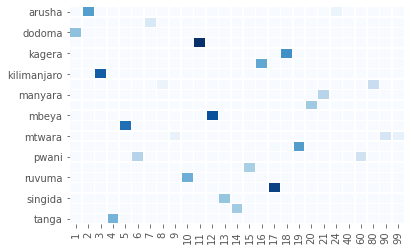

In [73]:
fig = plt.figure(figsize = (6, 4))

ct = pd.crosstab(df['region'], df['region_code'],normalize = True)
sns.heatmap(ct, linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')

fig.patch.set_visible(False)
plt.show()

It seems like region and region_code are same things, except region code has a few more values. I will drop region_code.

In [74]:
colstodrop = colstodrop + ['region_code']

##### Subvillages
Some subvillages has a lot of wells enough to affect the model, but most has less than 5, not enough to generalize. I will create new columns indicating how many other wells are in the village instead. I'll group the subvillages with less than 100 to be others group. It's still a lot of subvillages. I might consider dropping all together later if it doesn't do much.

In [75]:
# df.subvillage.nunique() # 19287 unique subvillages
sum(df.subvillage.value_counts() > 100) # most of them has less than 10 wells

23

In [76]:
subvil_counts = df.subvillage.value_counts()

In [77]:
# new column: n_wells_village
cond = [subvil_counts[df.subvillage] > 300, 
        subvil_counts[df.subvillage] > 100,
        subvil_counts[df.subvillage] > 50, subvil_counts[df.subvillage] > 10]
vals = ['more_than_300', 'more_than_100', 'more_than50', 'more_than_10']
df['n_wells_village'] = np.select(cond, vals, 'less_than_10')

In [78]:
# turn less than 100 wells village into 'others'
other_subvill =  [x for x in set(df.subvillage) if len(df[df.subvillage == x]) < 100]
df['subvillage'] = np.where(df.subvillage.isin(other_subvill), 'others', df.subvillage)

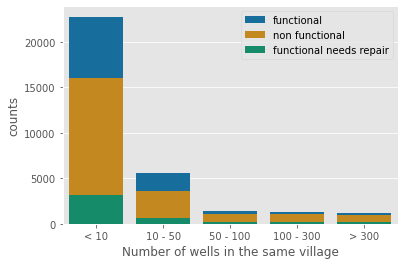

In [92]:
fig = plt.figure(figsize = (6, 4))

sns.countplot(hue = 'status_group', x = 'n_wells_village', dodge = False,
            data = df, order = ['less_than_10', 'more_than_10', 'more_than50', 'more_than_100', 'more_than_300'], 
              hue_order=['functional', 'non functional', 'functional needs repair'], palette = 'colorblind')

plt.xticks(range(0, 5), ['< 10', '10 - 50', '50 - 100', '100 - 300', '> 300'])
plt.xlabel('Number of wells in the same village')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

Mostly less than 10 wells in the same village. 

#### Get Basin Location
Approximate distance to basin is probably important predictor. We'll add this as a feature.


In [93]:
from geopy.geocoders import Nominatim

def get_lat_long(location):
    geolocator = Nominatim(user_agent = "Tanzwater")
    location = geolocator.geocode(location)
    return (location.longitude, location.latitude)

Getting basin long/lat.

In [94]:
basins = set(df.basin)
allbasins = dict.fromkeys(basins, ())
allbasins['ruvuma / southern coast'] = (38.31, -11.25)
allbasins['wami / ruvu'] = (37.6604, -6.8176)
allbasins['internal'] = (35, -4.5)

for bas in basins:
    if allbasins[bas] != (): continue
    try:
        allbasins[bas] = get_lat_long(bas)
    except AttributeError:
        bas_new = bas.title()
        try: allbasins[bas] = get_lat_long(bas_new)
        except: print(f"error: {bas_new}")

In [95]:
df['basin_lat'] = df.basin.apply(lambda x: allbasins[x][1])
df['basin_long'] = df.basin.apply(lambda x: allbasins[x][0])

#### New Features: Distance 
##### Distance to Basin
We'll calculate the distance to basin using Lat/Long

In [96]:
from geopy.distance import geodesic

def get_dist(crd1, crd2): 
    return geodesic(crd1, crd2).miles


In [97]:
df['dist_to_basin'] = df.apply(lambda x: get_dist((x.latitude, x.longitude), 
                            (x.basin_lat, x.basin_long)), axis = 1)

##### Distance to LGA center
Local Government Area is pretty arbitrary measure. But just to check how far it is from the well.

In [98]:
# fixing a typo
df.lga = df.lga.replace({'missungwi': 'misungwi', 'misenyi':'missenyi'})

In [99]:
# making a dictionary of long/lat
lgas = set(df.lga)
alllgas = dict.fromkeys(lgas, ())
for lga in lgas:
    try:
        lga_new = f"{lga.title()}, Tanzania"
        alllgas[lga] = get_lat_long(lga_new)
    except:
        lga_new = f"{lga.split(' ')[0].title()}, Tanzania"
        try: alllgas[lga] = get_lat_long(lga_new)
        except: print(f"error: {lga_new}")

In [100]:
df['lga_lat'] = df.lga.apply(lambda x: alllgas[x][1])
df['lga_long'] = df.lga.apply(lambda x: alllgas[x][0])

In [101]:
df['dist_to_lga'] = df.apply(lambda x: get_dist((x.latitude, x.longitude), 
                            (x.lga_lat, x.lga_long)), axis = 1)

In [102]:
df.lga_lat = df.lga_lat.astype('float')
df.lga_long = df.lga_long.astype('float')
df.basin_lat = df.basin_lat.astype('float')
df.basin_long = df.basin_long.astype('float')

#### Mapping Locations
Now we will visualize the well status along with basin and center of lga.

In [108]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

Shape file from (https://data.humdata.org/)


In [109]:
# creating geometry points to include 
crs = {'init': 'epsg:4326'}
geom = [Point(x, y) for x, y in zip(df.longitude, df.latitude)]
df1 = df.copy()
geo_df = gpd.GeoDataFrame(df1, crs = crs, geometry = geom)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [110]:
# geometry points for basins
d = {'basin': list(allbasins.keys()), 'geometry': [Point(x) for x in allbasins.values()]}
basin_geo_df = gpd.GeoDataFrame(d, crs = crs)

In [111]:
#geometry points for lga
d = {'lga': list(alllgas.keys()), 'geometry': [Point(x) for x in alllgas.values()]}
lga_geo_df = gpd.GeoDataFrame(d, crs = crs)

In [112]:
#loading tanzania shape file
tanz_map = gpd.read_file('MAP/tza_admbnda_adm3_20181019.shp')

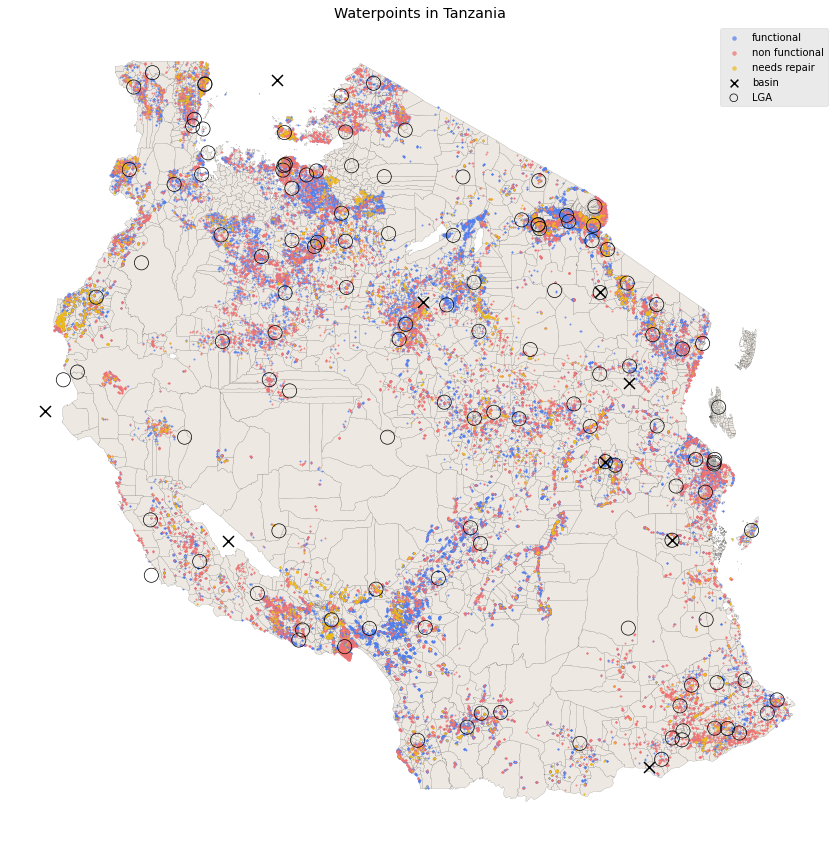

In [137]:
# plotting
fig, ax = plt.subplots(figsize = (15,15))
tanz_map.plot(ax = ax, edgecolor = 'black', lw = 0.1, color = '#ede8e1')
geo_df[geo_df.status_group == 'functional'].plot(ax = ax, markersize = 8, color = '#537fed', marker = '.', 
                                                label = 'functional', alpha = 0.7)
geo_df[geo_df.status_group == 'non functional'].plot(ax = ax, markersize = 8, color = '#f07373', marker = '.', 
                                                label = 'non functional', alpha = 0.7)
geo_df[geo_df.status_group == 'functional needs repair'].plot(ax = ax, markersize = 8, color = '#edbc1c', 
                                                              marker = '.', label = 'needs repair', alpha = 0.7)
basin_geo_df.plot(ax = ax, markersize = 120, color = 'black', marker = 'x', label = 'basin')
lga_geo_df.plot(ax = ax, markersize = 200, marker = 'o', 
                facecolor='none',
             linewidth=0.7, edgecolor='black', label = 'LGA')

lgn = plt.legend(bbox_to_anchor = [1,1])
for handle in lgn.legendHandles:
    handle.set_sizes([60])

ax.set_title('Waterpoints in Tanzania')
fig.patch.set_visible(False)
ax.axis('off')
plt.show()

##### LGA (Local Government Area)
We'll also group the ones that have less than 100 observations. But before, we will make a column indicating whether the lga is rural or urban.

In [141]:
df['urban_lga'] = df.lga.str.contains('urban')
df['rural_lga'] = df.lga.str.contains('rural')

In [142]:
# turn less than 100 wells into 'others'
other_lga =  [x for x in set(df.lga) if len(df[df.lga == x]) < 100]
df['lga'] = np.where(df.lga.isin(other_lga), 'others', df.lga)

#####  Wards
There are too many wards to process. Since wards are divided into 'Urban wards' and rural wards, we'll instead add a binary column indicating this, based on their names. 

In [145]:
df['urban_wards'] = df.ward.str.contains('urban')
df['rural_wards'] = df.ward.str.contains('rural')

In [146]:
colstodrop = colstodrop + ['ward']

### Types
There are several categorical information about the waterpoint. Let's see if they are not redundant and free of errors.

       ['scheme_management', 'scheme_name', 'permit', 
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group']

####  (Probably) useless features
The name of a person operating the waterpoint is not as important as the management. So we'll drop these columns.

In [147]:
colstodrop = colstodrop + ['scheme_name', 'recorded_by']

### Scheme Management
Not really a strong predictors, but we will leave them as is for now.

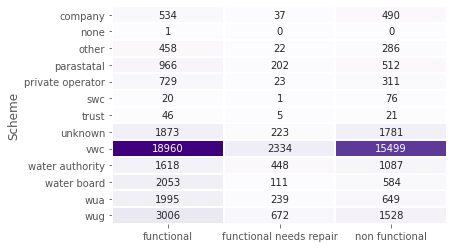

In [156]:
fig = plt.figure(figsize = (6, 4))

ct = pd.crosstab(df.scheme_management, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Purples')
plt.xlabel('')
plt.ylabel('Scheme')

fig.patch.set_visible(False)
plt.show()

In [62]:
# df.scheme_management.value_counts()

### Permit
Also not a strong predictor.

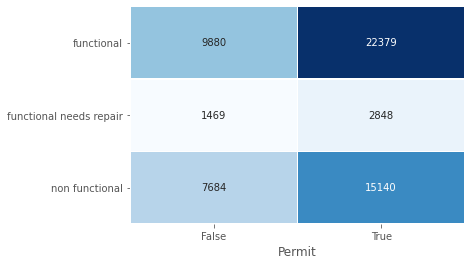

In [151]:
ct = pd.crosstab(df['status_group'], df['permit'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('Permit')
plt.ylabel('')
plt.show()


### Extraction type, group, class
There are extraction type and group and class. Let's see how they differ.

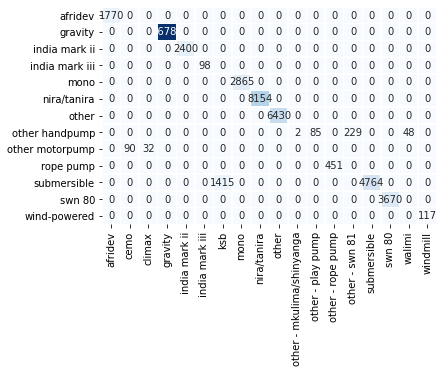

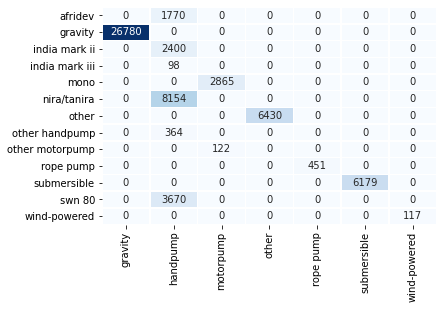

In [64]:
# extraction_type
ct = pd.crosstab(df['extraction_type_group'], df['extraction_type'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# extraction_type_class
ct = pd.crosstab(df['extraction_type_group'], df['extraction_type_class'])
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()


It seems like a same information but different scale of grouping. Types have some classes with 0 values so not all cases might be helpful. We'll combine extraction_type_group and extraction_type to have the most subdivisions but wiht at least 100 observations each.

In [153]:
chosen =  [x for x in set(df.extraction_type) if len(df[df.extraction_type == x]) > 100]
df['extraction_type_c'] = np.where(df.extraction_type.isin(chosen), df.extraction_type, df.extraction_type_group)

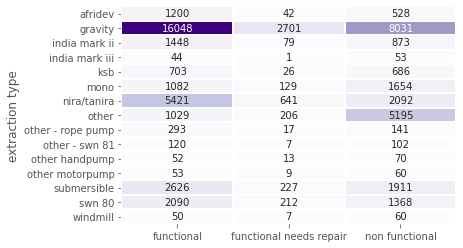

In [154]:
fig = plt.figure(figsize = (6, 4))

ct = pd.crosstab(df.extraction_type_c, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Purples')
plt.xlabel('')
plt.ylabel('extraction type')

fig.patch.set_visible(False)
plt.show()

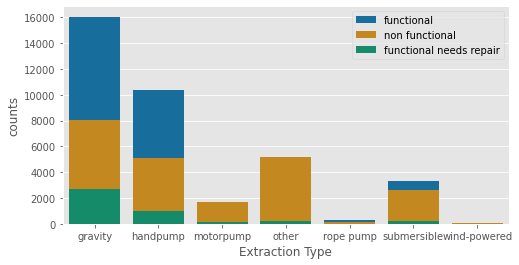

In [161]:
fig = plt.figure(figsize = (8, 4))

sns.countplot(hue = 'status_group', x = 'extraction_type_class', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Extraction Type')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

Most pumps are gravity pumps (environmentally sustainable) and handpump (old-fashioned). Electricity-based pumps are not doing well (motor, submersible).

In [66]:
colstodrop = colstodrop + ['extraction_type_class', 'extraction_type_group', 'extraction_type']

### Management & Management Group

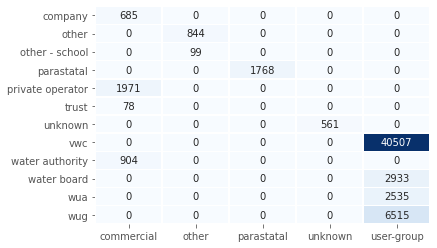

In [200]:
ct = pd.crosstab(df['management'], df['management_group'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

It seems like management group is just a larger category of management. Let's see if the subdivision has different relationship to target.

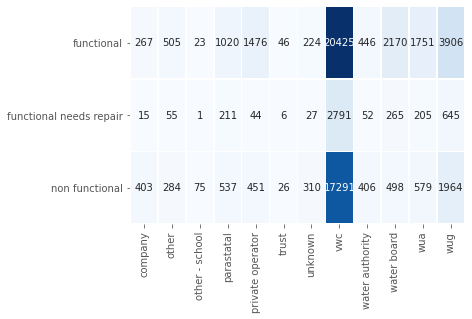

In [201]:
ct = pd.crosstab(df['status_group'], df['management'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

It does seem like subdivision has some effect (see other vs. other-school) So I'll keep management but remove management_group.

In [164]:
colstodrop = colstodrop + ['management_group']

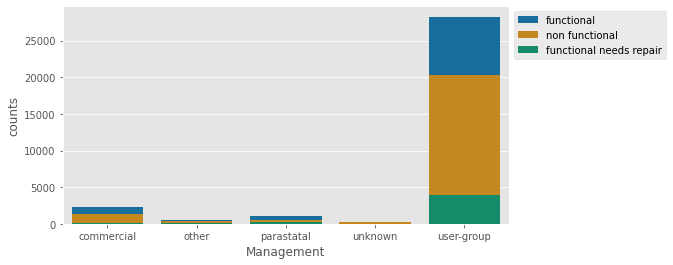

In [166]:
fig = plt.figure(figsize = (8, 4))

sns.countplot(hue = 'status_group', x = 'management_group', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Management')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

### Payment  vs. Payment type
Also looking at how payment and payment type differs.

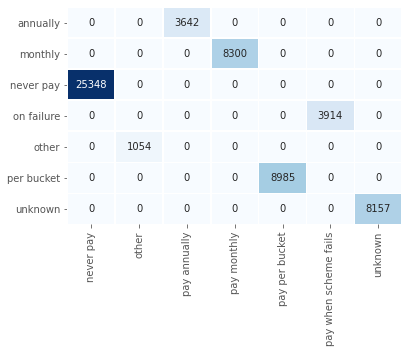

In [167]:
ct = pd.crosstab(df['payment_type'], df['payment'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()


Payment and payment type seem to be same values with slightly different labeling convention.

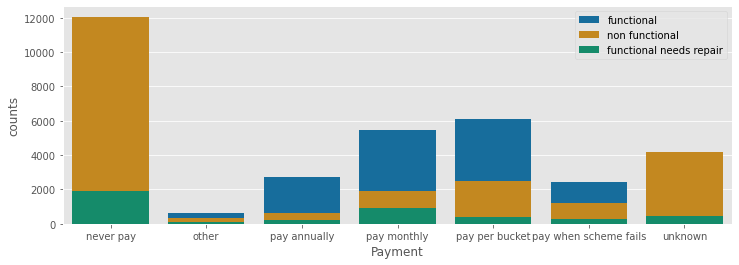

In [172]:
fig = plt.figure(figsize = (12, 4))

sns.countplot(hue = 'status_group', x = 'payment', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Payment')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

Sadly enough, payment does have a strong indication. Steadier payment is associated with the functionality. 

In [173]:
colstodrop = colstodrop + ['payment']

### Water quality, quality group

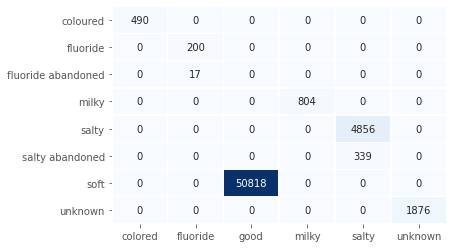

In [174]:
ct = pd.crosstab(df['water_quality'], df['quality_group'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

Very small divisions, we'll just keep water quality.

In [175]:
colstodrop = colstodrop + ['quality_group']

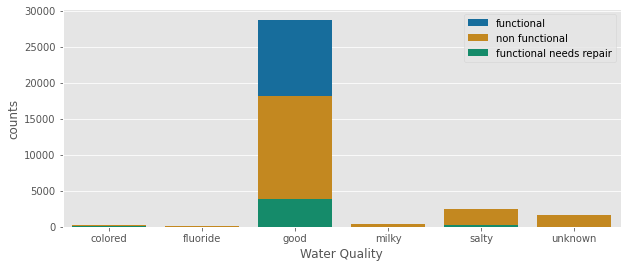

In [177]:
fig = plt.figure(figsize = (10, 4))

sns.countplot(hue = 'status_group', x = 'quality_group', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Water Quality')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

Mostly good, so it's hard to say but it also seems like other water quality are generally not functional. It's hard to reason the direction of causality. It can be that the functioning well means that the water is good. Or not a good quality water may have an effect of the pump function. 

### Quantity & Quantity Group

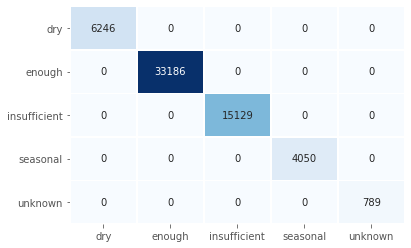

In [178]:
ct = pd.crosstab(df['quantity'], df['quantity_group'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [179]:
# same things keep just one
colstodrop = colstodrop + ['quantity_group']

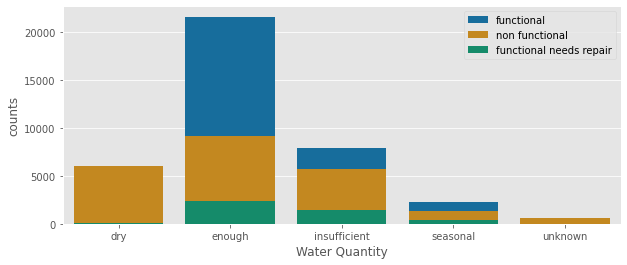

In [185]:
fig = plt.figure(figsize = (10, 4))

sns.countplot(hue = 'status_group', x = 'quantity_group', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Water Quantity')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

### Source vs. Source Type vs Source Class

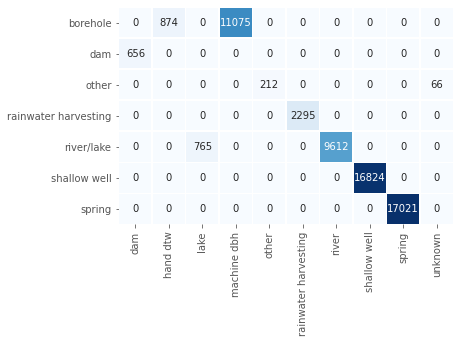

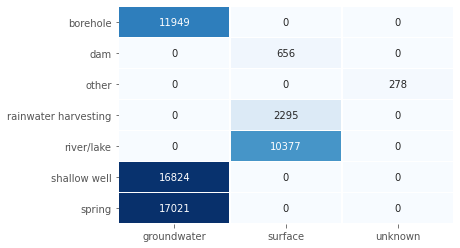

In [181]:
# source
ct = pd.crosstab(df['source_type'], df['source'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

ct = pd.crosstab(df['source_type'], df['source_class'])
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()


Source and Source Type are the same. Let's see if subdivision has any different effect on the target.

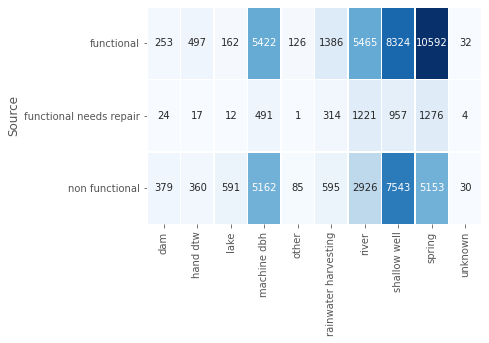

In [182]:
ct = pd.crosstab(df['status_group'], df['source'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('Source')
plt.show()

Okay, it seems like subdivisions of sources are pretty important. We will keep this and remove the source class

In [183]:
colstodrop = colstodrop + ['source_type', 'source_class']

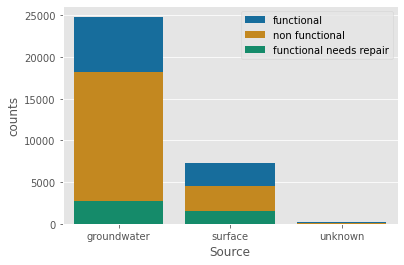

In [187]:
fig = plt.figure(figsize = (6, 4))

sns.countplot(hue = 'status_group', x = 'source_class', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Source')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

Mostly groundwater.

### Waterpoint type vs. Waterpoint type group
I'll take a look at the difference between waterpoint type and waterpoint type group.

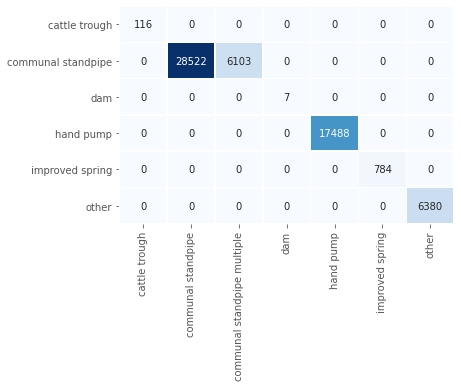

In [188]:
# waterpoint_type
ct = pd.crosstab(df['waterpoint_type_group'], df['waterpoint_type'])
sns.heatmap(ct, annot=True,  fmt = '.0f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

It seems like overall trend is the same, except for the waterpoint type divided the communal standpipe to two categories. We should probably just use waterpoint type and not waterpoint type group. Since subgroup changes the pattern slightly.

In [189]:
colstodrop = colstodrop + ['waterpoint_type_group']

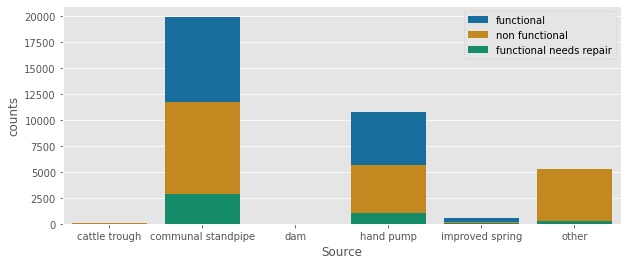

In [194]:
fig = plt.figure(figsize = (10, 4))

sns.countplot(hue = 'status_group', x = 'waterpoint_type_group', dodge = False,
            data = df, hue_order=['functional', 'non functional', 'functional needs repair'], 
              palette = 'colorblind')

plt.xlabel('Source')
plt.ylabel('counts')
plt.legend(bbox_to_anchor = [1, 1])
fig.patch.set_visible(False)
plt.show()

In [195]:
# dataframe with these columns removed
subdf = df.drop(colstodrop, axis = 1)

## Train/Test Split
We'll now split the dataset, and export them for model evaluation.

In [196]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

y = subdf['status_group']
X = subdf.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20)

In [197]:
pd.to_pickle(X, 'PKL/X_full.pkl')
pd.to_pickle(y, 'PKL/y_full.pkl')

pd.to_pickle(X_train, 'PKL/X_train.pkl')
pd.to_pickle(X_test, 'PKL/X_test.pkl')
pd.to_pickle(y_train, 'PKL/y_train.pkl')
pd.to_pickle(y_test, 'PKL/y_test.pkl')

In [198]:
# just in case 
#X_train.to_csv('CSV_temp/X_train.csv')
#X_test.to_csv('CSV_temp/X_test.csv')
#y_train.to_csv('CSV_temp/y_train.csv')
#y_test.to_csv('CSV_temp/y_test.csv')